# Linear regression with numpy

### 1-layer classification by gradient descent

### The dataset:

- A set of reviews of different beers
- Has 5 different review ratings between 1-5
- Palate, appearance, taste, aroma
- And overall

Our task: 
- Is it possible to guess the overall rating from the previous 4 ratings?

## Defining our neural network

![](1_layer_neural_network.png)



Our 1-layer neural network
$$
y = g(\sum_i w_i x_i + b) 
$$

- $b$ is the bias, 
- $g$ the activation function. In our case: g(a) = a 
- $w_i$ weight for input $x_i$




### Imports

In [5]:
import numpy as np # Scientific calculation library
import json # To read .json file (Not required for assignment 1)
import matplotlib.pyplot as plt # Plotting library

### Read in our data

In [6]:
def read_data(path):
  x_keys = [
    "review/palate",
    "review/appearance",
    "review/taste",
    "review/aroma"
  ]
  with open(path, "r") as f:
    all_lines = f.readlines()
    X = np.zeros((len(all_lines), len(x_keys)))
    Y = np.zeros((len(all_lines), 1))
    for idx, line in enumerate(all_lines):
      dic = json.loads(line)
      x = [dic[key] for key in x_keys]
      y = dic["review/overall"]
      X[idx] = x
      Y[idx] = y
  return X, Y

In [7]:
X_train, Y_train = read_data("beers2.json")
# Lets only use the 1,000 first examples for now.
X_train = X_train[:1000]
Y_train = Y_train[:1000]

print("X shape:", X_train.shape)
print("X max: {}, X min: {}".format(X_train.max(), X_train.min()))
print("Y shape:", Y_train.shape)
print("Y max: {}, Y min: {}".format(Y_train.max(), Y_train.min()))

FileNotFoundError: [Errno 2] No such file or directory: 'beers2.json'

### Example data point


In [24]:
print("X: {}. Y: {}".format(X_train[0], Y_train[0]))

X: [4.  4.  3.5 4.  1. ]. Y: [4.]


### The bias trick

Concatenating a "1" to each $x_i$, such that we can ignore the bias. 

Then, we get:
$$
y = g(\sum_i w_i x_i) 
$$
In vector format this is:
$$
y = w \cdot x
$$ 

In [4]:
X_train = np.concatenate((X_train, np.ones((X_train.shape[0], 1))), axis=1)
print("X shape with bias:", X_train.shape)

X shape with bias: (1000, 5)


### Split data into train and validation

- Use validation set to prevent data-snooping on test set.
- Required in real-world scenarios (where we have no test-set!)

In [5]:
def train_val_split(X, Y, val_percentage):
  """
    Selects samples from the dataset randomly to be in the validation set. Also, shuffles the train set.
    --
    X: [N, num_features] numpy vector,
    Y: [N, 1] numpy vector
    val_percentage: amount of data to put in validation set
  """
  dataset_size = X.shape[0]
  idx = np.arange(0, dataset_size)
  np.random.shuffle(idx) 
  
  train_size = int(dataset_size*(1-val_percentage))
  idx_train = idx[:train_size]
  idx_val = idx[train_size:]
  X_train, Y_train = X[idx_train], Y[idx_train]
  X_val, Y_val = X[idx_val], Y[idx_val]
  return X_train, Y_train, X_val, Y_val

In [6]:
# Use 10% for validation
X_train, Y_train, X_val, Y_val = train_val_split(X_train, Y_train, 0.1) 
print("Train shape: X: {}, Y: {}".format(X_train.shape, Y_train.shape))
print("Validation shape: X: {}, Y: {}".format(X_val.shape, Y_val.shape))

Train shape: X: (900, 5), Y: (900, 1)
Validation shape: X: (100, 5), Y: (100, 1)


## Objective function: Mean squared error

In this example, we are performing linear regression with gradient descent

Our objective function or error function is:

$$
E = \frac{1}{N} \sum_{n=0}^N (t^n - y^n)^2
$$,
where: 

- $N$: Number of data samples
- $t^n$: target value (or label) for sample $n$
- $y^n$: output of our neural network for sample $n$

In [7]:
def mse_loss(targets, outputs):
  assert targets.shape == outputs.shape
  squared_error = (targets - outputs) ** 2
  mean_squared_error = squared_error.mean()
  return mean_squared_error

### Forward pass:

We have
$$
y = w \cdot x
$$ 

In [8]:
def forward_pass(X, w):
  return X.dot(w)

### Mini-batch Gradient descent

$$
w_{t+1} = w_t - \alpha \sum_{n=1}^{N} \frac{\partial E^n(w)}{\partial w}
$$

First, we need to find $\frac{\partial E^n(w)}{\partial w}$


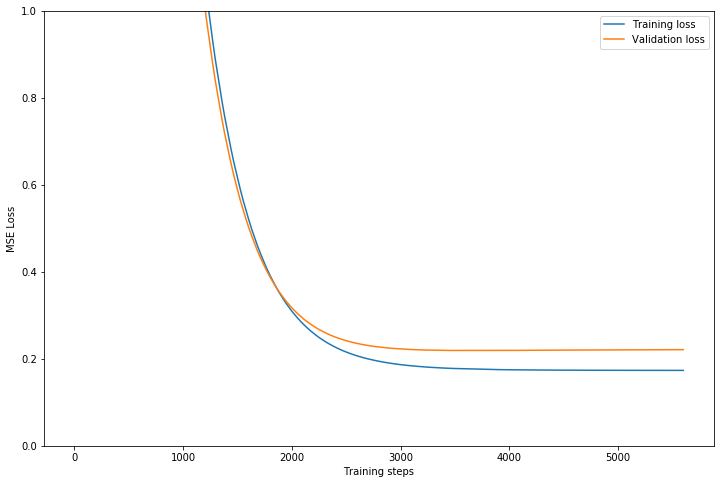

In [12]:
plt.show()

![text](gradient_descent_derivation.png) 


$$
\frac{\partial E^n}{\partial w_i} = \frac{\partial E^n}{\partial y^n} \frac{\partial y^n}{\partial a^n} \frac{\partial a^n }{\partial w_i}
$$


#### Quick reminder:
$$
E^n =  (t^n - y^n)^2, \\
y^n = a^n, \\
a = \sum_{i} w_i x_i
$$
$y^n = a^n$ because we are using no activation function, will be different for sigmoid!

Then,
$$
\frac{\partial E^n}{\partial y^n} = - 2 (t^n -y^n), \\
\frac{\partial y^n}{\partial a^n} = 1, \\
\frac{\partial a^n}{\partial w_i} = x^n_i
$$





Finally,
$$
\frac{\partial E^n}{\partial w_i} = \frac{\partial E^n}{\partial y^n} \frac{\partial y^n}{\partial a^n} \frac{\partial a^n }{\partial w_i}
$$

$$
\frac{\partial E^n}{\partial w_i} = - 2(t^n - y^n) x^n_i
$$

In [1]:
def gradient_decent(X, outputs, targets, weights, learning_rate):
  N = X.shape[0]
  # Important to check that your vectors/matrices have the expected shape
  assert outputs.shape == targets.shape
  for i in range(weights.shape[0]):
    dw_i = - 2 * (targets - outputs) * X[:, i:i+1] # 
    expected_shape = (N, 1)
    assert dw_i.shape == expected_shape, "\
    dw_j shape was: {}. Expected: {}".format(dw_i.shape, expected_shape)
    
    dw_i = dw_i.mean(axis=0) # Normalize gradient, take mean over all training examples
    weights[i] = weights[i] - learning_rate * dw_i
  return weights
    

In [2]:
# Tracking variables
TRAIN_LOSS = []
VAL_LOSS = []
TRAINING_STEP = []
num_features = X_train.shape[1]

num_batches_per_epoch = X_train.shape[0] // batch_size
check_step = num_batches_per_epoch // 10 # How often we should calculate validation / train loss

NameError: name 'X_train' is not defined

In [3]:

# Hyperparameters
epochs = 200
batch_size = 32
learning_rate = 0.00001

In [4]:
w = np.zeros((num_features, 1))

def train_loop(w):
  training_it = 0
  for epoch in range(epochs):
    #shuffle(X_train, Y_train)
    for i in range(num_batches_per_epoch):
      training_it += 1
      X_batch = X_train[i*batch_size:(i+1)*batch_size]
      Y_batch = Y_train[i*batch_size:(i+1)*batch_size]

      out = forward_pass(X_batch, w)
      w = gradient_decent(X_batch, out, Y_batch, w, learning_rate)

      if i % check_step == 0:
        # Training set
        train_out = forward_pass(X_train, w)
        train_loss = mse_loss(Y_train, train_out)
        TRAIN_LOSS.append(train_loss)
        TRAINING_STEP.append(training_it)
        
        val_out = forward_pass(X_val, w)
        val_loss = mse_loss(Y_val, val_out)
        VAL_LOSS.append(val_loss)
  return w

w = train_loop(w)
    
  

NameError: name 'np' is not defined

In [2]:
plt.figure(figsize=(12, 8 ))
plt.ylim([0, 1])
plt.xlabel("Training steps")
plt.ylabel("MSE Loss")
plt.plot(TRAINING_STEP, TRAIN_LOSS, label="Training loss")
plt.plot(TRAINING_STEP, VAL_LOSS, label="Validation loss")
plt.legend() # Shows graph labels

NameError: name 'plt' is not defined

### Final MSE

In [13]:
print("MSE training set:", TRAIN_LOSS[-1])
print("MSE validation set:", VAL_LOSS[-1])

MSE training set: 0.17338991372293203
MSE validation set: 0.22108528411064732


### Vectorize it! 

- Update all weights at the same time
- Runs significantly faster
- Easier to read?

In [14]:
def gradient_decent(X, outputs, targets, weights, learning_rate):
  N = X.shape[0]
  # Important to check that your vectors/matrices have the expected shape
  assert outputs.shape == targets.shape

  dw = X * 2*(targets-outputs)
  dw = dw.mean(axis = 0).reshape(-1, 1) # Normalize gradient w.r.t number of training samples
  assert dw.shape == weights.shape, "dw: {}, w: {}".format(dw.shape, weights.shape)
  weights = weights + learning_rate * dw
  return weights

In [19]:
w = np.zeros((num_features, 1))
# Tracking variables
TRAIN_LOSS = []
VAL_LOSS = []
TRAINING_STEP = []

num_batches_per_epoch = X_train.shape[0] // batch_size
check_step = num_batches_per_epoch // 10 # How often we should calculate validation / train loss

w = train_loop(w)
    
  

In [20]:
plt.figure(figsize=(12, 8 ))
plt.ylim([0, 2])
plt.plot(TRAINING_STEP, TRAIN_LOSS, label="Training loss")
plt.plot(TRAINING_STEP, VAL_LOSS, label="Validation loss")
plt.legend() # Shows graph labels

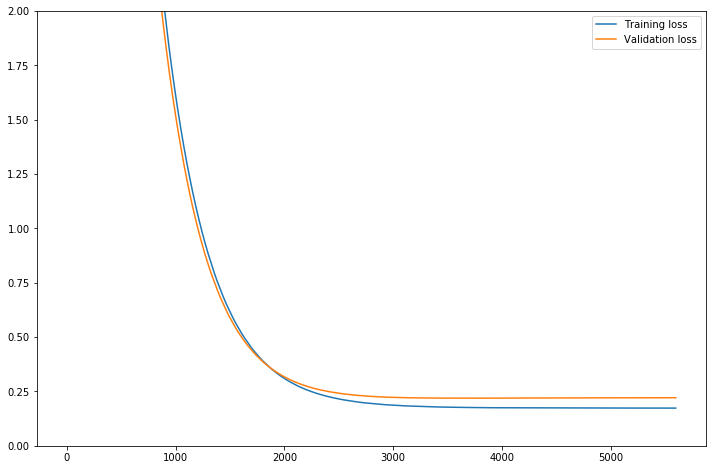

In [21]:
plt.show()

# Questions?